In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
## Environment
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/models'):
    main_path = p[:-len('/models')]
sys.path[0] = main_path

import os, gc
from termcolor import colored
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from src import (config, fe, features, feature_selection, 
                 preprocess, training)
from src.fe import CreateFeatures

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# DATA PREPARATION
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

# Combine train and valid labels
trvl_labels = pd.concat([train_labels, valid_labels], axis = 0)

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Define SAM testbed files
sam_files = metadata[(metadata.instrument_type == 'sam_testbed') & (metadata.split == 'train')]['features_path']
sam_files = sam_files.to_dict()

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

# SAM testbed labels
sam_labels = train_labels.drop(train_labels.tail(len(sam_files)).index)
sam_labels = pd.concat([sam_labels, valid_labels], axis=0)
print(f'Labels w/o SAM : {sam_labels.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)
['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']
Labels w/o SAM : (1047, 11)


In [6]:
FTS_NAME = 'fts_peak_widths'                 # Name of the file with features
COMPUTE_FTS = False                         # Should the features be recomputed
COMPUTE_FTS_SAM = False                      # Compute SAM test bed
MODEL_ALGO = 'XGB_opt'                      # Name of the classifier
MODEL_NAME = FTS_NAME + '_' + MODEL_ALGO    # Name of the model
FTS_SELECT = True

**COMPUTE FEATURES**

- Change the `fe._` method depending on the feature that we wish to calculate

In [7]:
# Check if feature is computed and load it or choose to compute it
check_file = 0
for i in ['_tr', '_trvl', '_vlte']:
    check_file += os.path.exists(os.path.join(config.DATA_DIR_OUT, FTS_NAME +
                                              str(i) + '.csv'))

if (check_file == 3) & (not COMPUTE_FTS):
    print('Reading features ... ')
    X_tr = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_tr.csv'))
    print(X_tr.shape)
    X_trvl = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_trvl.csv'))
    print(X_trvl.shape)
    X_vlte = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_vlte.csv'))
    print(X_vlte.shape)
    
else:
    print('Computing features ... ')
    # ----- TRAIN -----
    fe = CreateFeatures(metadata, train_files, 'tr', FTS_NAME)
    X_tr = fe.fts_peak_widths(no_peaks_calc=4)
    print(colored(f'train => {X_tr.shape}', 'blue'))
    
    # ----- TRAIN & VALID -----
    fe = CreateFeatures(metadata, trva_files, 'trvl', FTS_NAME)
    X_trvl = fe.fts_peak_widths(no_peaks_calc=4)
    print(colored(f'train => {X_trvl.shape}', 'blue'))
    
    # ----- VALID & TEST -----
    fe = CreateFeatures(metadata, all_test_files, 'vlte', FTS_NAME)
    X_vlte = fe.fts_peak_widths(no_peaks_calc=4)
    print(colored(f'train => {X_vlte.shape}', 'blue'))
    
if COMPUTE_FTS_SAM:
    print(f'\nCreating SAM testbed samples ...')
    # Training without SAM testbed
    X_tr_sam = X_tr.drop(X_tr.tail(len(sam_files)).index).copy()
    X_tr_sam = pd.concat([X_tr_sam, X_trvl.iloc[len(train_files):,:]], axis=0)
    print(f'Train shape: {X_tr_sam.shape}')
    # Validation data
    X_vl_sam = X_tr.tail(len(sam_files)).copy()
    print(f'Valid shape: {X_vl_sam.shape}')

Reading features ... 
(766, 1200)
(1059, 1200)
(804, 1200)


## MODELS

**TRAIN**

In [8]:
if FTS_SELECT:
    _, SFM_COLUMNS = feature_selection.fts_select(
        target_labels_list, FTS_NAME, MODEL_NAME, MODEL_ALGO, 'tr',
        X_tr, X_vlte, train_labels, valid_files, valid_labels
    )
else:
    SFM_COLUMNS = None

../models/fts_peak_widths_XGB_opt_tr_sfmt.csv
Computing thresholds ...


  0%|          | 0/10 [00:00<?, ?it/s]

LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.22220851721439935


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.2161031804181025


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.2210803327544786


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.21805618411770772


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.22494615152567218


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.2341502779332282


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.23615942329824696


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.22300562172819807
Threshold=0.008, n=766, log-loss: 0.24073003688922515


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.2255787961868372
Threshold=0.01, n=766, log-loss: 0.2682306123730558


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.011, n=766, log-loss: 0.2845254538464757
Threshold=0.012, n=766, log-loss: 0.274038842303119


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.013000000000000001, n=766, log-loss: 0.27793550845664694
Threshold=0.014, n=766, log-loss: 0.2736230267151402


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.015, n=766, log-loss: 0.27991967422112113
Threshold=0.016, n=766, log-loss: 0.2723578930210239


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.017, n=766, log-loss: 0.2689533188006183
Threshold=0.018000000000000002, n=766, log-loss: 0.2822112839497346
Threshold=0.019, n=766, log-loss: 0.2822112839497346


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.2822112839497346
Threshold=0.021, n=766, log-loss: 0.2822112839497346
Threshold=0.022, n=766, log-loss: 0.2822112839497346


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.023, n=766, log-loss: 0.2822112839497346
Threshold=0.024, n=766, log-loss: 0.2822112839497346
Threshold=0.025, n=766, log-loss: 0.2822112839497346


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.026000000000000002, n=766, log-loss: 0.2822112839497346
Threshold=0.027, n=766, log-loss: 0.2822112839497346
Threshold=0.028, n=766, log-loss: 0.2822112839497346


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.029, n=766, log-loss: 0.3096404502123798
Threshold=0.03, n=766, log-loss: 0.3096404502123798
Threshold=0.031, n=766, log-loss: 0.3096404502123798


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.032, n=766, log-loss: 0.3096404502123798
Threshold=0.033, n=766, log-loss: 0.3096404502123798
Threshold=0.034, n=766, log-loss: 0.3096404502123798


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.035, n=766, log-loss: 0.3096404502123798
Threshold=0.036000000000000004, n=766, log-loss: 0.30909561897936333
Threshold=0.037, n=766, log-loss: 0.30909561897936333
Threshold=0.038, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.039, n=766, log-loss: 0.30909561897936333
Threshold=0.04, n=766, log-loss: 0.30909561897936333
Threshold=0.041, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.042, n=766, log-loss: 0.30909561897936333
Threshold=0.043000000000000003, n=766, log-loss: 0.30909561897936333
Threshold=0.044, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.045, n=766, log-loss: 0.30909561897936333
Threshold=0.046, n=766, log-loss: 0.30909561897936333
Threshold=0.047, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.048, n=766, log-loss: 0.30909561897936333
Threshold=0.049, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.05, n=766, log-loss: 0.30909561897936333
Threshold=0.051000000000000004, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.052000000000000005, n=766, log-loss: 0.30909561897936333
Threshold=0.053, n=766, log-loss: 0.30909561897936333
Threshold=0.054, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.055, n=766, log-loss: 0.30909561897936333
Threshold=0.056, n=766, log-loss: 0.30909561897936333
Threshold=0.057, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.058, n=766, log-loss: 0.30909561897936333
Threshold=0.059000000000000004, n=766, log-loss: 0.30909561897936333
Threshold=0.06, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.061, n=766, log-loss: 0.30909561897936333
Threshold=0.062, n=766, log-loss: 0.30909561897936333
Threshold=0.063, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.064, n=766, log-loss: 0.30909561897936333
Threshold=0.065, n=766, log-loss: 0.30909561897936333
Threshold=0.066, n=766, log-loss: 0.30909561897936333


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 10%|

Threshold=0.067, n=766, log-loss: 0.30909561897936333
Threshold=0.068, n=766, log-loss: 0.30909561897936333
Threshold=0.069, n=766, log-loss: 0.30909561897936333
LABEL: carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.2358009138505321


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.23027149668069075


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.23813647430933657


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.24737872616542858


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.25360834980705343


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.2579331050148955
Threshold=0.006, n=766, log-loss: 0.2828567627791169


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.2951699042469883
Threshold=0.008, n=766, log-loss: 0.29568094322251304


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.2964381801136118
Threshold=0.01, n=766, log-loss: 0.29203525195200214


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.3126556269471683
Threshold=0.012, n=766, log-loss: 0.30832714821850093


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.013000000000000001, n=766, log-loss: 0.31774990015493154
Threshold=0.014, n=766, log-loss: 0.3251734142687963


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.015, n=766, log-loss: 0.33241266484845927
Threshold=0.016, n=766, log-loss: 0.33297326577050174


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.017, n=766, log-loss: 0.33297326577050174
Threshold=0.018000000000000002, n=766, log-loss: 0.3186404262530322


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.019, n=766, log-loss: 0.3257484534813358
Threshold=0.02, n=766, log-loss: 0.31215763688898


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.021, n=766, log-loss: 0.33351543150626045
Threshold=0.022, n=766, log-loss: 0.33351543150626045


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.023, n=766, log-loss: 0.33351543150626045
Threshold=0.024, n=766, log-loss: 0.33351543150626045


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.025, n=766, log-loss: 0.24902453320776352
Threshold=0.026000000000000002, n=766, log-loss: 0.2948625977929847


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.027, n=766, log-loss: 0.2948625977929847
Threshold=0.028, n=766, log-loss: 0.2948625977929847


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.029, n=766, log-loss: 0.2948625977929847
Threshold=0.03, n=766, log-loss: 0.2948625977929847


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.031, n=766, log-loss: 0.2948625977929847
Threshold=0.032, n=766, log-loss: 0.2948625977929847
Threshold=0.033, n=766, log-loss: 0.2948625977929847


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.034, n=766, log-loss: 0.2948625977929847
Threshold=0.035, n=766, log-loss: 0.2948625977929847
Threshold=0.036000000000000004, n=766, log-loss: 0.2948625977929847


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.037, n=766, log-loss: 0.2948625977929847
Threshold=0.038, n=766, log-loss: 0.3152050007096533
Threshold=0.039, n=766, log-loss: 0.3152050007096533


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.04, n=766, log-loss: 0.3152050007096533
Threshold=0.041, n=766, log-loss: 0.3152050007096533
Threshold=0.042, n=766, log-loss: 0.3152050007096533


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.043000000000000003, n=766, log-loss: 0.3152050007096533
Threshold=0.044, n=766, log-loss: 0.3368285197777349
Threshold=0.045, n=766, log-loss: 0.3368285197777349


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.046, n=766, log-loss: 0.3368285197777349
Threshold=0.047, n=766, log-loss: 0.3368285197777349


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.048, n=766, log-loss: 0.3368285197777349
Threshold=0.049, n=766, log-loss: 0.3368285197777349


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.05, n=766, log-loss: 0.3368285197777349
Threshold=0.051000000000000004, n=766, log-loss: 0.3368285197777349


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.052000000000000005, n=766, log-loss: 0.3368285197777349
Threshold=0.053, n=766, log-loss: 0.3368285197777349
Threshold=0.054, n=766, log-loss: 0.3368285197777349


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 20%|██        | 2/10 [00:20<01:23, 10.40s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.055, n=766, log-loss: 0.3368285197777349
LABEL: chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.33385386402915795


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.3320135805398661


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.33264858523660273


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.3285318025826467


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.3244673659013419


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.3209338375933805
Threshold=0.006, n=766, log-loss: 0.31922643948481466


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.35127496282405574
Threshold=0.008, n=766, log-loss: 0.3399953115207013


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.40095431174496476
Threshold=0.01, n=766, log-loss: 0.37278345212222747


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.3853766262203887
Threshold=0.012, n=766, log-loss: 0.3809906697479226


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.013000000000000001, n=766, log-loss: 0.3879994236667078
Threshold=0.014, n=766, log-loss: 0.38525490159226056


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.015, n=766, log-loss: 0.3907833722310376
Threshold=0.016, n=766, log-loss: 0.37467675161493924
Threshold=0.017, n=766, log-loss: 0.40691348980260383


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.40691348980260383
Threshold=0.019, n=766, log-loss: 0.40691348980260383
Threshold=0.02, n=766, log-loss: 0.40691348980260383


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.021, n=766, log-loss: 0.430886941513765
Threshold=0.022, n=766, log-loss: 0.430886941513765
Threshold=0.023, n=766, log-loss: 0.430886941513765


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.024, n=766, log-loss: 0.430886941513765
Threshold=0.025, n=766, log-loss: 0.430886941513765
Threshold=0.026000000000000002, n=766, log-loss: 0.430886941513765


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.027, n=766, log-loss: 0.430886941513765
Threshold=0.028, n=766, log-loss: 0.430886941513765
Threshold=0.029, n=766, log-loss: 0.430886941513765


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 30%|███       | 3/10 [00:28<01:04,  9.17s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.03, n=766, log-loss: 0.430886941513765
Threshold=0.031, n=766, log-loss: 0.430886941513765
LABEL: iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.34130315118113297


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.3378953516722495


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.34407993136434706


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.3424458183521411


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.37886831316613806


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.3497234494631964


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.35179131760169774
Threshold=0.007, n=766, log-loss: 0.38331444560686834


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.3823943711879247
Threshold=0.009000000000000001, n=766, log-loss: 0.39501710813142893


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.01, n=766, log-loss: 0.40309417135489045
Threshold=0.011, n=766, log-loss: 0.4035331198743802


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.41348437293442186
Threshold=0.013000000000000001, n=766, log-loss: 0.4546703305421238


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.46796269352633646
Threshold=0.015, n=766, log-loss: 0.46796269352633646


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.016, n=766, log-loss: 0.50153473842692
Threshold=0.017, n=766, log-loss: 0.5009936319247728
Threshold=0.018000000000000002, n=766, log-loss: 0.5513619627523849

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Threshold=0.019, n=766, log-loss: 0.5513619627523849


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 40%|████      | 4/10 [00:35<00:49,  8.22s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.5513619627523849
Threshold=0.021, n=766, log-loss: 0.5338006266217946
LABEL: oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.026783267987666354
Threshold=0.001, n=766, log-loss: 0.029933838429423716


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.02812289449313986
Threshold=0.003, n=766, log-loss: 0.02890359635866937


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.031278256344395995
Threshold=0.005, n=766, log-loss: 0.03276148217344027


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.026373263780637913
Threshold=0.007, n=766, log-loss: 0.030686919454448625


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.02843362353912971


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.027350612531444725
Threshold=0.01, n=766, log-loss: 0.02567087318120467


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.011, n=766, log-loss: 0.025418910979445857
Threshold=0.012, n=766, log-loss: 0.03918128623070875
Threshold=0.013000000000000001, n=766, log-loss: 0.03918128623070875


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.014, n=766, log-loss: 0.04483935535061348
Threshold=0.015, n=766, log-loss: 0.04580967687805415
Threshold=0.016, n=766, log-loss: 0.058127559961253655


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.017, n=766, log-loss: 0.058127559961253655
Threshold=0.018000000000000002, n=766, log-loss: 0.05397759224768925
Threshold=0.019, n=766, log-loss: 0.05125320784877922


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.02, n=766, log-loss: 0.05125320784877922
Threshold=0.021, n=766, log-loss: 0.053350928440767914
Threshold=0.022, n=766, log-loss: 0.053350928440767914


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.023, n=766, log-loss: 0.053350928440767914
Threshold=0.024, n=766, log-loss: 0.053350928440767914
Threshold=0.025, n=766, log-loss: 0.053350928440767914


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.026000000000000002, n=766, log-loss: 0.053350928440767914
Threshold=0.027, n=766, log-loss: 0.053350928440767914
Threshold=0.028, n=766, log-loss: 0.053350928440767914


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.029, n=766, log-loss: 0.053350928440767914
Threshold=0.03, n=766, log-loss: 0.053350928440767914
Threshold=0.031, n=766, log-loss: 0.05431498284054342


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.032, n=766, log-loss: 0.05431498284054342
Threshold=0.033, n=766, log-loss: 0.09559593961888817
Threshold=0.034, n=766, log-loss: 0.09559593961888817


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.035, n=766, log-loss: 0.09559593961888817
Threshold=0.036000000000000004, n=766, log-loss: 0.09559593961888817
Threshold=0.037, n=766, log-loss: 0.13715272619621033
Threshold=0.038, n=766, log-loss: 0.13715272619621033


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.039, n=766, log-loss: 0.13715272619621033
Threshold=0.04, n=766, log-loss: 0.13715272619621033
Threshold=0.041, n=766, log-loss: 0.13715272619621033
Threshold=0.042, n=766, log-loss: 0.13715272619621033


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.043000000000000003, n=766, log-loss: 0.13715272619621033
Threshold=0.044, n=766, log-loss: 0.13715272619621033
Threshold=0.045, n=766, log-loss: 0.13715272619621033


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.046, n=766, log-loss: 0.13715272619621033
Threshold=0.047, n=766, log-loss: 0.13715272619621033
Threshold=0.048, n=766, log-loss: 0.13715272619621033


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.049, n=766, log-loss: 0.13715272619621033
Threshold=0.05, n=766, log-loss: 0.13715272619621033
Threshold=0.051000000000000004, n=766, log-loss: 0.13715272619621033


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.052000000000000005, n=766, log-loss: 0.13715272619621033
Threshold=0.053, n=766, log-loss: 0.13715272619621033
Threshold=0.054, n=766, log-loss: 0.13715272619621033


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.055, n=766, log-loss: 0.12881261050230713
Threshold=0.056, n=766, log-loss: 0.12881261050230713
Threshold=0.057, n=766, log-loss: 0.12881261050230713
Threshold=0.058, n=766, log-loss: 0.12881261050230713


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.059000000000000004, n=766, log-loss: 0.12881261050230713
Threshold=0.06, n=766, log-loss: 0.12881261050230713
Threshold=0.061, n=766, log-loss: 0.12881261050230713
Threshold=0.062, n=766, log-loss: 0.12881261050230713


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.063, n=766, log-loss: 0.12881261050230713
Threshold=0.064, n=766, log-loss: 0.12881261050230713
Threshold=0.065, n=766, log-loss: 0.12881261050230713
Threshold=0.066, n=766, log-loss: 0.12881261050230713


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.067, n=766, log-loss: 0.12881261050230713
Threshold=0.068, n=766, log-loss: 0.12881261050230713
Threshold=0.069, n=766, log-loss: 0.12881261050230713
Threshold=0.07, n=766, log-loss: 0.12881261050230713


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.07100000000000001, n=766, log-loss: 0.12881261050230713
Threshold=0.07200000000000001, n=766, log-loss: 0.12881261050230713
Threshold=0.073, n=766, log-loss: 0.13731698148308558


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.074, n=766, log-loss: 0.13731698148308558
Threshold=0.075, n=766, log-loss: 0.13731698148308558
Threshold=0.076, n=766, log-loss: 0.13731698148308558


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.077, n=766, log-loss: 0.13731698148308558
Threshold=0.078, n=766, log-loss: 0.13731698148308558
Threshold=0.079, n=766, log-loss: 0.13731698148308558
Threshold=0.08, n=766, log-loss: 0.13731698148308558


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.081, n=766, log-loss: 0.13731698148308558
Threshold=0.082, n=766, log-loss: 0.13731698148308558
Threshold=0.083, n=766, log-loss: 0.13731698148308558
Threshold=0.084, n=766, log-loss: 0.13731698148308558


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.085, n=766, log-loss: 0.13731698148308558
Threshold=0.08600000000000001, n=766, log-loss: 0.13731698148308558
Threshold=0.08700000000000001, n=766, log-loss: 0.13731698148308558
Threshold=0.088, n=766, log-loss: 0.13731698148308558


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.089, n=766, log-loss: 0.13731698148308558
Threshold=0.09, n=766, log-loss: 0.13731698148308558
Threshold=0.091, n=766, log-loss: 0.13731698148308558


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.092, n=766, log-loss: 0.13731698148308558
Threshold=0.093, n=766, log-loss: 0.13731698148308558
Threshold=0.094, n=766, log-loss: 0.1345765299446652
Threshold=0.095, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.096, n=766, log-loss: 0.1345765299446652
Threshold=0.097, n=766, log-loss: 0.1345765299446652
Threshold=0.098, n=766, log-loss: 0.1345765299446652
Threshold=0.099, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.1, n=766, log-loss: 0.1345765299446652
Threshold=0.101, n=766, log-loss: 0.1345765299446652
Threshold=0.10200000000000001, n=766, log-loss: 0.1345765299446652
Threshold=0.10300000000000001, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.10400000000000001, n=766, log-loss: 0.1345765299446652
Threshold=0.105, n=766, log-loss: 0.1345765299446652
Threshold=0.106, n=766, log-loss: 0.1345765299446652
Threshold=0.107, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.108, n=766, log-loss: 0.1345765299446652
Threshold=0.109, n=766, log-loss: 0.1345765299446652
Threshold=0.11, n=766, log-loss: 0.1345765299446652
Threshold=0.111, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.112, n=766, log-loss: 0.1345765299446652
Threshold=0.113, n=766, log-loss: 0.1345765299446652
Threshold=0.114, n=766, log-loss: 0.1345765299446652
Threshold=0.115, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.116, n=766, log-loss: 0.1345765299446652
Threshold=0.117, n=766, log-loss: 0.1345765299446652
Threshold=0.11800000000000001, n=766, log-loss: 0.1345765299446652
Threshold=0.11900000000000001, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.12, n=766, log-loss: 0.1345765299446652
Threshold=0.121, n=766, log-loss: 0.1345765299446652
Threshold=0.122, n=766, log-loss: 0.1345765299446652
Threshold=0.123, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.124, n=766, log-loss: 0.1345765299446652
Threshold=0.125, n=766, log-loss: 0.1345765299446652
Threshold=0.126, n=766, log-loss: 0.1345765299446652
Threshold=0.127, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.128, n=766, log-loss: 0.1345765299446652
Threshold=0.129, n=766, log-loss: 0.1345765299446652
Threshold=0.13, n=766, log-loss: 0.1345765299446652
Threshold=0.131, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.132, n=766, log-loss: 0.1345765299446652
Threshold=0.133, n=766, log-loss: 0.1345765299446652
Threshold=0.134, n=766, log-loss: 0.1345765299446652
Threshold=0.135, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.136, n=766, log-loss: 0.1345765299446652
Threshold=0.137, n=766, log-loss: 0.1345765299446652
Threshold=0.138, n=766, log-loss: 0.1345765299446652
Threshold=0.139, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.14, n=766, log-loss: 0.1345765299446652
Threshold=0.14100000000000001, n=766, log-loss: 0.1345765299446652
Threshold=0.14200000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.14300000000000002, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.14400000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.145, n=766, log-loss: 0.1345765299446652
Threshold=0.146, n=766, log-loss: 0.1345765299446652
Threshold=0.147, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.148, n=766, log-loss: 0.1345765299446652
Threshold=0.149, n=766, log-loss: 0.1345765299446652
Threshold=0.15, n=766, log-loss: 0.1345765299446652
Threshold=0.151, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.152, n=766, log-loss: 0.1345765299446652
Threshold=0.153, n=766, log-loss: 0.1345765299446652
Threshold=0.154, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.155, n=766, log-loss: 0.1345765299446652
Threshold=0.156, n=766, log-loss: 0.1345765299446652
Threshold=0.157, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.158, n=766, log-loss: 0.1345765299446652
Threshold=0.159, n=766, log-loss: 0.1345765299446652
Threshold=0.16, n=766, log-loss: 0.1345765299446652
Threshold=0.161, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.162, n=766, log-loss: 0.1345765299446652
Threshold=0.163, n=766, log-loss: 0.1345765299446652
Threshold=0.164, n=766, log-loss: 0.1345765299446652
Threshold=0.165, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.166, n=766, log-loss: 0.1345765299446652
Threshold=0.167, n=766, log-loss: 0.1345765299446652
Threshold=0.168, n=766, log-loss: 0.1345765299446652
Threshold=0.169, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.17, n=766, log-loss: 0.1345765299446652
Threshold=0.171, n=766, log-loss: 0.1345765299446652
Threshold=0.17200000000000001, n=766, log-loss: 0.1345765299446652
Threshold=0.17300000000000001, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.17400000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.17500000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.176, n=766, log-loss: 0.1345765299446652
Threshold=0.177, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.178, n=766, log-loss: 0.1345765299446652
Threshold=0.179, n=766, log-loss: 0.1345765299446652
Threshold=0.18, n=766, log-loss: 0.1345765299446652
Threshold=0.181, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.182, n=766, log-loss: 0.1345765299446652
Threshold=0.183, n=766, log-loss: 0.1345765299446652
Threshold=0.184, n=766, log-loss: 0.1345765299446652
Threshold=0.185, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.186, n=766, log-loss: 0.1345765299446652
Threshold=0.187, n=766, log-loss: 0.1345765299446652
Threshold=0.188, n=766, log-loss: 0.1345765299446652
Threshold=0.189, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.19, n=766, log-loss: 0.1345765299446652
Threshold=0.191, n=766, log-loss: 0.1345765299446652
Threshold=0.192, n=766, log-loss: 0.1345765299446652
Threshold=0.193, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.194, n=766, log-loss: 0.1345765299446652
Threshold=0.195, n=766, log-loss: 0.1345765299446652
Threshold=0.196, n=766, log-loss: 0.1345765299446652
Threshold=0.197, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.198, n=766, log-loss: 0.1345765299446652
Threshold=0.199, n=766, log-loss: 0.1345765299446652
Threshold=0.2, n=766, log-loss: 0.1345765299446652
Threshold=0.201, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.202, n=766, log-loss: 0.1345765299446652
Threshold=0.203, n=766, log-loss: 0.1345765299446652
Threshold=0.20400000000000001, n=766, log-loss: 0.1345765299446652
Threshold=0.20500000000000002, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.20600000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.20700000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.20800000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.209, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.21, n=766, log-loss: 0.1345765299446652
Threshold=0.211, n=766, log-loss: 0.1345765299446652
Threshold=0.212, n=766, log-loss: 0.1345765299446652
Threshold=0.213, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.214, n=766, log-loss: 0.1345765299446652
Threshold=0.215, n=766, log-loss: 0.1345765299446652
Threshold=0.216, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.217, n=766, log-loss: 0.1345765299446652
Threshold=0.218, n=766, log-loss: 0.1345765299446652
Threshold=0.219, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.22, n=766, log-loss: 0.1345765299446652
Threshold=0.221, n=766, log-loss: 0.1345765299446652
Threshold=0.222, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.223, n=766, log-loss: 0.1345765299446652
Threshold=0.224, n=766, log-loss: 0.1345765299446652
Threshold=0.225, n=766, log-loss: 0.1345765299446652
Threshold=0.226, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.227, n=766, log-loss: 0.1345765299446652
Threshold=0.228, n=766, log-loss: 0.1345765299446652
Threshold=0.229, n=766, log-loss: 0.1345765299446652
Threshold=0.23, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.231, n=766, log-loss: 0.1345765299446652
Threshold=0.232, n=766, log-loss: 0.1345765299446652
Threshold=0.233, n=766, log-loss: 0.1345765299446652
Threshold=0.234, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.23500000000000001, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.23600000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.23700000000000002, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.23800000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.23900000000000002, n=766, log-loss: 0.1345765299446652
Threshold=0.24, n=766, log-loss: 0.1345765299446652
Threshold=0.241, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.242, n=766, log-loss: 0.1345765299446652
Threshold=0.243, n=766, log-loss: 0.1345765299446652
Threshold=0.244, n=766, log-loss: 0.1345765299446652
Threshold=0.245, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.246, n=766, log-loss: 0.1345765299446652
Threshold=0.247, n=766, log-loss: 0.1345765299446652
Threshold=0.248, n=766, log-loss: 0.1345765299446652
Threshold=0.249, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.25, n=766, log-loss: 0.1345765299446652
Threshold=0.251, n=766, log-loss: 0.1345765299446652
Threshold=0.252, n=766, log-loss: 0.1345765299446652
Threshold=0.253, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.254, n=766, log-loss: 0.1345765299446652
Threshold=0.255, n=766, log-loss: 0.1345765299446652
Threshold=0.256, n=766, log-loss: 0.1345765299446652
Threshold=0.257, n=766, log-loss: 0.1345765299446652


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.258, n=766, log-loss: 0.1345765299446652
Threshold=0.259, n=766, log-loss: 0.1345765299446652
Threshold=0.26, n=766, log-loss: 0.1345765299446652
Threshold=0.261, n=766, log-loss: 0.1345765299446652
LABEL: oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.23081845469508994


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.24404206249621338


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.24009929445600806


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.2455247864230463


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.2522579206077465


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.2890422045564718


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.2951700211512147
Threshold=0.007, n=766, log-loss: 0.30145546735968415


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.2964179066892669
Threshold=0.009000000000000001, n=766, log-loss: 0.3187204662808964


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.01, n=766, log-loss: 0.3352444925148409
Threshold=0.011, n=766, log-loss: 0.43025368243080814


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.4380419243511715
Threshold=0.013000000000000001, n=766, log-loss: 0.4464348270144606


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.4687607454186871
Threshold=0.015, n=766, log-loss: 0.4687607454186871


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.016, n=766, log-loss: 0.4687607454186871
Threshold=0.017, n=766, log-loss: 0.4712584042594269


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.4887767509770271
Threshold=0.019, n=766, log-loss: 0.4887767509770271


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.4887767509770271
Threshold=0.021, n=766, log-loss: 0.4887767509770271
Threshold=0.022, n=766, log-loss: 0.5011988856317953


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.023, n=766, log-loss: 0.49409207712808056
Threshold=0.024, n=766, log-loss: 0.4880703633504923
Threshold=0.025, n=766, log-loss: 0.4880703633504923


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.4880703633504923
Threshold=0.027, n=766, log-loss: 0.4880703633504923
Threshold=0.028, n=766, log-loss: 0.4880703633504923


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.029, n=766, log-loss: 0.4760230880726523
Threshold=0.03, n=766, log-loss: 0.4760230880726523
Threshold=0.031, n=766, log-loss: 0.4760230880726523


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.032, n=766, log-loss: 0.4760230880726523
Threshold=0.033, n=766, log-loss: 0.4760230880726523
Threshold=0.034, n=766, log-loss: 0.4760230880726523


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.035, n=766, log-loss: 0.4760230880726523
Threshold=0.036000000000000004, n=766, log-loss: 0.4883196223972194
Threshold=0.037, n=766, log-loss: 0.4883196223972194


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.038, n=766, log-loss: 0.4883196223972194
Threshold=0.039, n=766, log-loss: 0.4883196223972194


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.04, n=766, log-loss: 0.4883196223972194


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.041, n=766, log-loss: 0.4883196223972194


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.042, n=766, log-loss: 0.4883196223972194


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 60%|██████    | 6/10 [01:03<00:44, 11.16s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.043000000000000003, n=766, log-loss: 0.4883196223972194
Threshold=0.044, n=766, log-loss: 0.4883196223972194
LABEL: phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.3284906453656433


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.333353566748818


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.324590591196473


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.33338859794604186


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.3804511357024916


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.400347226478935


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.4183523209293535
Threshold=0.007, n=766, log-loss: 0.4189407300464682


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.44246842051775165
Threshold=0.009000000000000001, n=766, log-loss: 0.43670653292127337


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.01, n=766, log-loss: 0.4608710496559256
Threshold=0.011, n=766, log-loss: 0.4827299139092107


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.526555638455185
Threshold=0.013000000000000001, n=766, log-loss: 0.508071182422823


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.5528879236436287
Threshold=0.015, n=766, log-loss: 0.5907344524414873


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.016, n=766, log-loss: 0.5907344524414873
Threshold=0.017, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.5971261940311653
Threshold=0.019, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.5971261940311653
Threshold=0.021, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.5971261940311653
Threshold=0.023, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.5971261940311653
Threshold=0.025, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.5971261940311653
Threshold=0.027, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.028, n=766, log-loss: 0.5971261940311653
Threshold=0.029, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.03, n=766, log-loss: 0.5971261940311653
Threshold=0.031, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.032, n=766, log-loss: 0.5971261940311653
Threshold=0.033, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.034, n=766, log-loss: 0.5971261940311653
Threshold=0.035, n=766, log-loss: 0.5971261940311653


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 70%|███████   | 7/10 [01:14<00:32, 10.90s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.036000000000000004, n=766, log-loss: 0.5971261940311653
Threshold=0.037, n=766, log-loss: 0.5971261940311653
LABEL: silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.2632264378639542


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.26408937006911465


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.27107667822709447


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.2665269193799734


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.27362794359512593


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.2724349604637057


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.2878278275938234


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.2713827016022781


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.281222248912603


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.32667975948107153
Threshold=0.01, n=766, log-loss: 0.31051440110629575


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.2923136187916774
Threshold=0.012, n=766, log-loss: 0.29735310871389287


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.013000000000000001, n=766, log-loss: 0.30280167823649445
Threshold=0.014, n=766, log-loss: 0.3092217879717909


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.015, n=766, log-loss: 0.31381276692601506
Threshold=0.016, n=766, log-loss: 0.31381276692601506
Threshold=0.017, n=766, log-loss: 0.31381276692601506


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.30491990059711127
Threshold=0.019, n=766, log-loss: 0.30491990059711127
Threshold=0.02, n=766, log-loss: 0.30491990059711127

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Threshold=0.021, n=766, log-loss: 0.3126973369808028


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.3126973369808028
Threshold=0.023, n=766, log-loss: 0.3126973369808028


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.3099831392914661
Threshold=0.025, n=766, log-loss: 0.3099831392914661


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.3099831392914661
Threshold=0.027, n=766, log-loss: 0.3101691591725033


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.028, n=766, log-loss: 0.34821803860188344
Threshold=0.029, n=766, log-loss: 0.34821803860188344
Threshold=0.03, n=766, log-loss: 0.34821803860188344


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.031, n=766, log-loss: 0.34821803860188344
Threshold=0.032, n=766, log-loss: 0.34821803860188344


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.033, n=766, log-loss: 0.34821803860188344
Threshold=0.034, n=766, log-loss: 0.34821803860188344


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.035, n=766, log-loss: 0.34821803860188344
Threshold=0.036000000000000004, n=766, log-loss: 0.34821803860188344


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.037, n=766, log-loss: 0.34821803860188344
Threshold=0.038, n=766, log-loss: 0.34821803860188344


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.039, n=766, log-loss: 0.34821803860188344
Threshold=0.04, n=766, log-loss: 0.34821803860188344
Threshold=0.041, n=766, log-loss: 0.34821803860188344


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.042, n=766, log-loss: 0.34821803860188344
Threshold=0.043000000000000003, n=766, log-loss: 0.34821803860188344
Threshold=0.044, n=766, log-loss: 0.34821803860188344


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.045, n=766, log-loss: 0.34821803860188344
Threshold=0.046, n=766, log-loss: 0.34821803860188344
Threshold=0.047, n=766, log-loss: 0.34821803860188344
LABEL: sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.3071227828871122


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.32141330998562556


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.32236059758066815


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.33293519852764003


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.338898609136867


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.3623070481011593
Threshold=0.006, n=766, log-loss: 0.40401326629941897


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.4181868279394106
Threshold=0.008, n=766, log-loss: 0.424174965030288


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.4075098101513734
Threshold=0.01, n=766, log-loss: 0.42093826401279444


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.42585873643076205
Threshold=0.012, n=766, log-loss: 0.4138956460005162


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.013000000000000001, n=766, log-loss: 0.425974558337207
Threshold=0.014, n=766, log-loss: 0.4301350953624784


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.015, n=766, log-loss: 0.4794017662089191
Threshold=0.016, n=766, log-loss: 0.4794017662089191


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.017, n=766, log-loss: 0.4767698676535167
Threshold=0.018000000000000002, n=766, log-loss: 0.49052035464005667


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.019, n=766, log-loss: 0.4717090249430299
Threshold=0.02, n=766, log-loss: 0.4717090249430299


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.021, n=766, log-loss: 0.4717090249430299
Threshold=0.022, n=766, log-loss: 0.4717090249430299


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.023, n=766, log-loss: 0.4717090249430299
Threshold=0.024, n=766, log-loss: 0.4717090249430299
Threshold=0.025, n=766, log-loss: 0.49797441937512504


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.49797441937512504
Threshold=0.027, n=766, log-loss: 0.49797441937512504
Threshold=0.028, n=766, log-loss: 0.49797441937512504


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.029, n=766, log-loss: 0.49797441937512504
Threshold=0.03, n=766, log-loss: 0.49797441937512504
Threshold=0.031, n=766, log-loss: 0.49797441937512504


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.032, n=766, log-loss: 0.49797441937512504
Threshold=0.033, n=766, log-loss: 0.49797441937512504
Threshold=0.034, n=766, log-loss: 0.49797441937512504


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.035, n=766, log-loss: 0.49797441937512504
Threshold=0.036000000000000004, n=766, log-loss: 0.49797441937512504


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.037, n=766, log-loss: 0.49797441937512504
Threshold=0.038, n=766, log-loss: 0.49797441937512504


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 90%|

Threshold=0.039, n=766, log-loss: 0.49797441937512504
Threshold=0.04, n=766, log-loss: 0.49797441937512504
LABEL: sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.08564953262136563


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.08429181416369594


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.08194616061568566


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.08275835451776473
Threshold=0.004, n=766, log-loss: 0.08987703937031932


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.08983678698325975
Threshold=0.006, n=766, log-loss: 0.09649155229515215


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.0993385265645676
Threshold=0.008, n=766, log-loss: 0.10137028169322365


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.10024082620227677
Threshold=0.01, n=766, log-loss: 0.10387587637931375


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.10387587637931375
Threshold=0.012, n=766, log-loss: 0.1022977065275115


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.013000000000000001, n=766, log-loss: 0.09095166371869076
Threshold=0.014, n=766, log-loss: 0.08957909624554763


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.015, n=766, log-loss: 0.09912019724037448
Threshold=0.016, n=766, log-loss: 0.11217897381127331


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.017, n=766, log-loss: 0.11268699671870491
Threshold=0.018000000000000002, n=766, log-loss: 0.11268699671870491


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.019, n=766, log-loss: 0.11268699671870491
Threshold=0.02, n=766, log-loss: 0.11424686778900961


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.021, n=766, log-loss: 0.1415627945288809
Threshold=0.022, n=766, log-loss: 0.1415627945288809


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.023, n=766, log-loss: 0.15301670268183548
Threshold=0.024, n=766, log-loss: 0.19414484717981706
Threshold=0.025, n=766, log-loss: 0.19414484717981706


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.026000000000000002, n=766, log-loss: 0.19414484717981706
Threshold=0.027, n=766, log-loss: 0.20214312479778831
Threshold=0.028, n=766, log-loss: 0.20214312479778831


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.029, n=766, log-loss: 0.20214312479778831
Threshold=0.03, n=766, log-loss: 0.20214312479778831


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.031, n=766, log-loss: 0.19190539309275004
Threshold=0.032, n=766, log-loss: 0.19190539309275004
Threshold=0.033, n=766, log-loss: 0.18147428823736697


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.034, n=766, log-loss: 0.18147428823736697
Threshold=0.035, n=766, log-loss: 0.18147428823736697


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.036000000000000004, n=766, log-loss: 0.18147428823736697
Threshold=0.037, n=766, log-loss: 0.18215915481734754
Threshold=0.038, n=766, log-loss: 0.18215915481734754


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.039, n=766, log-loss: 0.18215915481734754
Threshold=0.04, n=766, log-loss: 0.18215915481734754
Threshold=0.041, n=766, log-loss: 0.18215915481734754


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.042, n=766, log-loss: 0.18215915481734754
Threshold=0.043000000000000003, n=766, log-loss: 0.18215915481734754
Threshold=0.044, n=766, log-loss: 0.18215915481734754


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.045, n=766, log-loss: 0.18215915481734754
Threshold=0.046, n=766, log-loss: 0.18215915481734754


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.047, n=766, log-loss: 0.18215915481734754
Threshold=0.048, n=766, log-loss: 0.18215915481734754
Threshold=0.049, n=766, log-loss: 0.18215915481734754


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.05, n=766, log-loss: 0.18215915481734754
Threshold=0.051000000000000004, n=766, log-loss: 0.18215915481734754
Threshold=0.052000000000000005, n=766, log-loss: 0.18215915481734754


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.053, n=766, log-loss: 0.18215915481734754
Threshold=0.054, n=766, log-loss: 0.18215915481734754
Threshold=0.055, n=766, log-loss: 0.18215915481734754


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.056, n=766, log-loss: 0.18215915481734754
Threshold=0.057, n=766, log-loss: 0.1847959089461625
Computing columns ...


  0%|          | 0/10 [00:00<?, ?it/s]

LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 10%|█         | 1/10 [00:00<00:04,  1.82it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=170, log-loss: 0.2161031804181025
LABEL: carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 20%|██        | 2/10 [00:01<00:04,  1.86it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=160, log-loss: 0.23027149668069075
LABEL: chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 30%|███       | 3/10 [00:01<00:03,  2.25it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=54, log-loss: 0.31922643948481466
LABEL: iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 40%|████      | 4/10 [00:02<00:03,  1.73it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 50%|█████     | 5/10 [00:02<00:02,  2.45it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=220, log-loss: 0.3378953516722495
LABEL: oxalate
N=17, log-loss: 0.025418910979445857
LABEL: oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 60%|██████    | 6/10 [00:04<00:04,  1.01s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=1200, log-loss: 0.23081845469508994
LABEL: phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 70%|███████   | 7/10 [00:05<00:02,  1.16it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=177, log-loss: 0.324590591196473
LABEL: silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 80%|████████  | 8/10 [00:07<00:02,  1.26s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=1200, log-loss: 0.2632264378639542
LABEL: sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 90%|█████████ | 9/10 [00:09<00:01,  1.55s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=1200, log-loss: 0.3071227828871122
LABEL: sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

N=103, log-loss: 0.08194616061568566


In [9]:
for label in SFM_COLUMNS:
    print(label, len(SFM_COLUMNS[label]))

basalt 170
carbonate 160
chloride 54
iron_oxide 220
oxalate 17
oxychlorine 1200
phyllosilicate 177
silicate 1200
sulfate 1200
sulfide 103


CV training ....
basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

Full training .....
LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


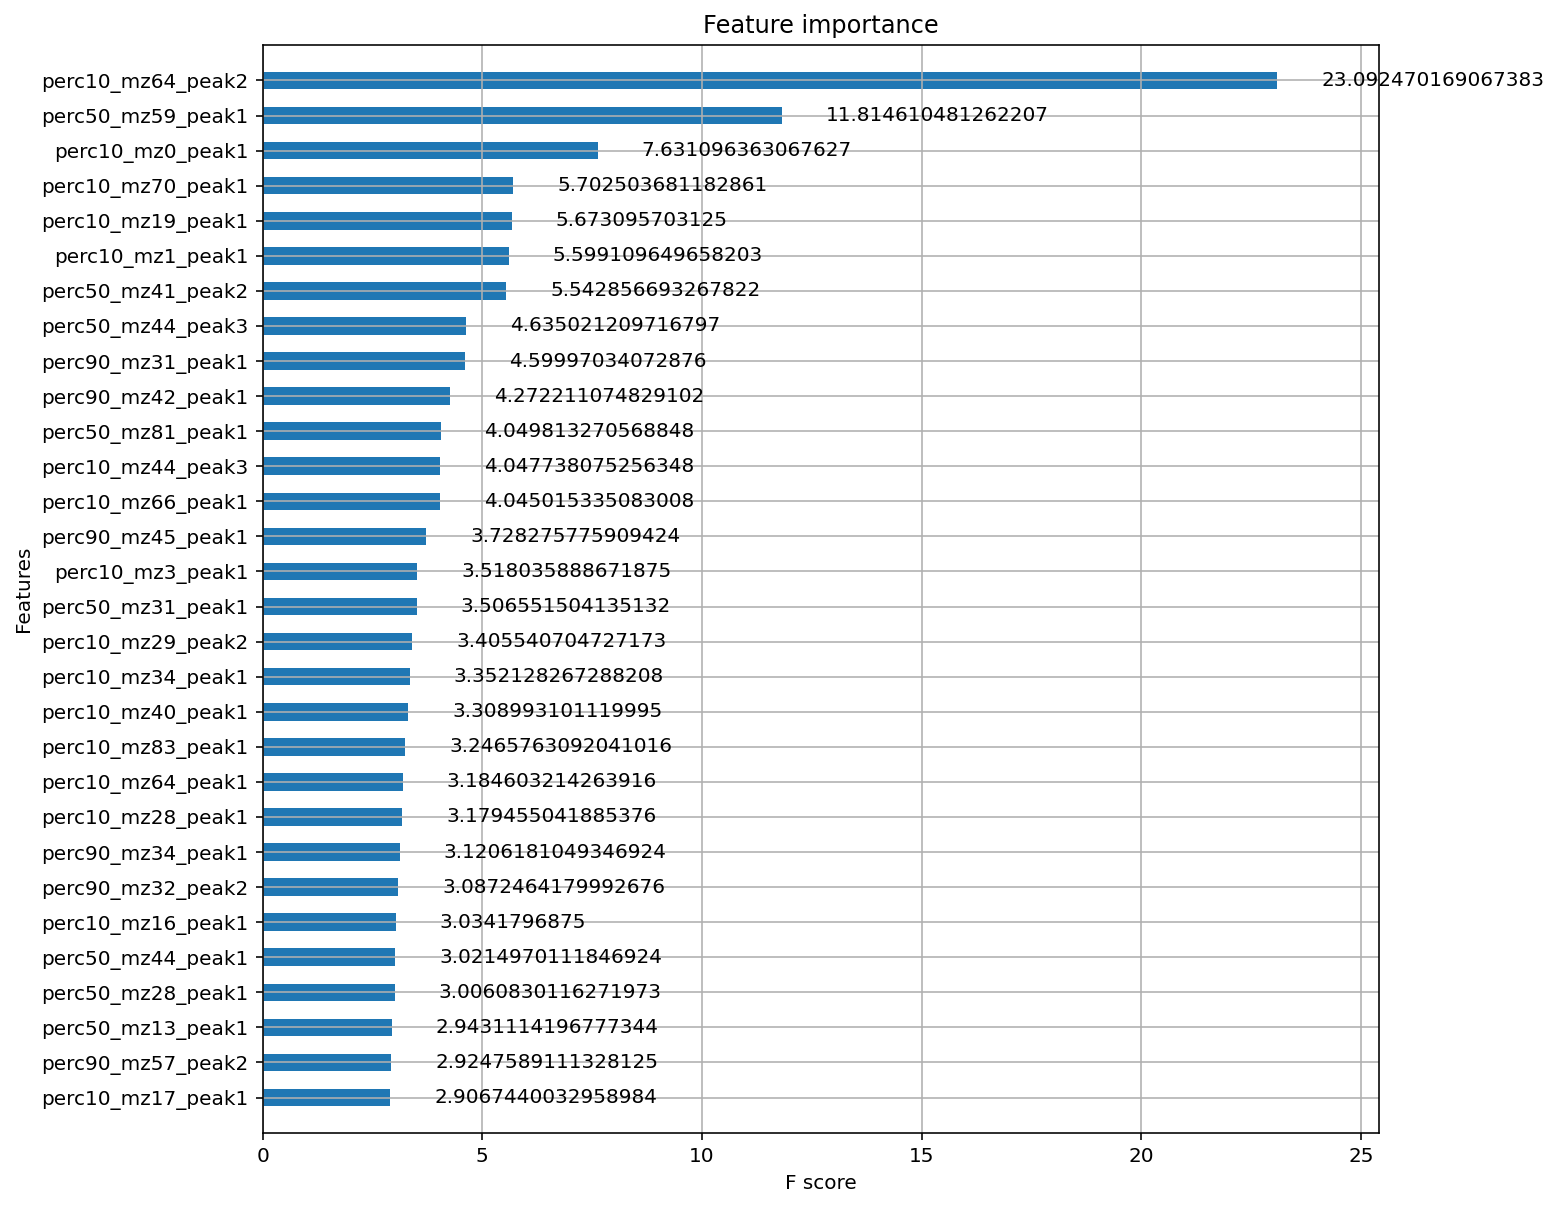

LABEL: carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


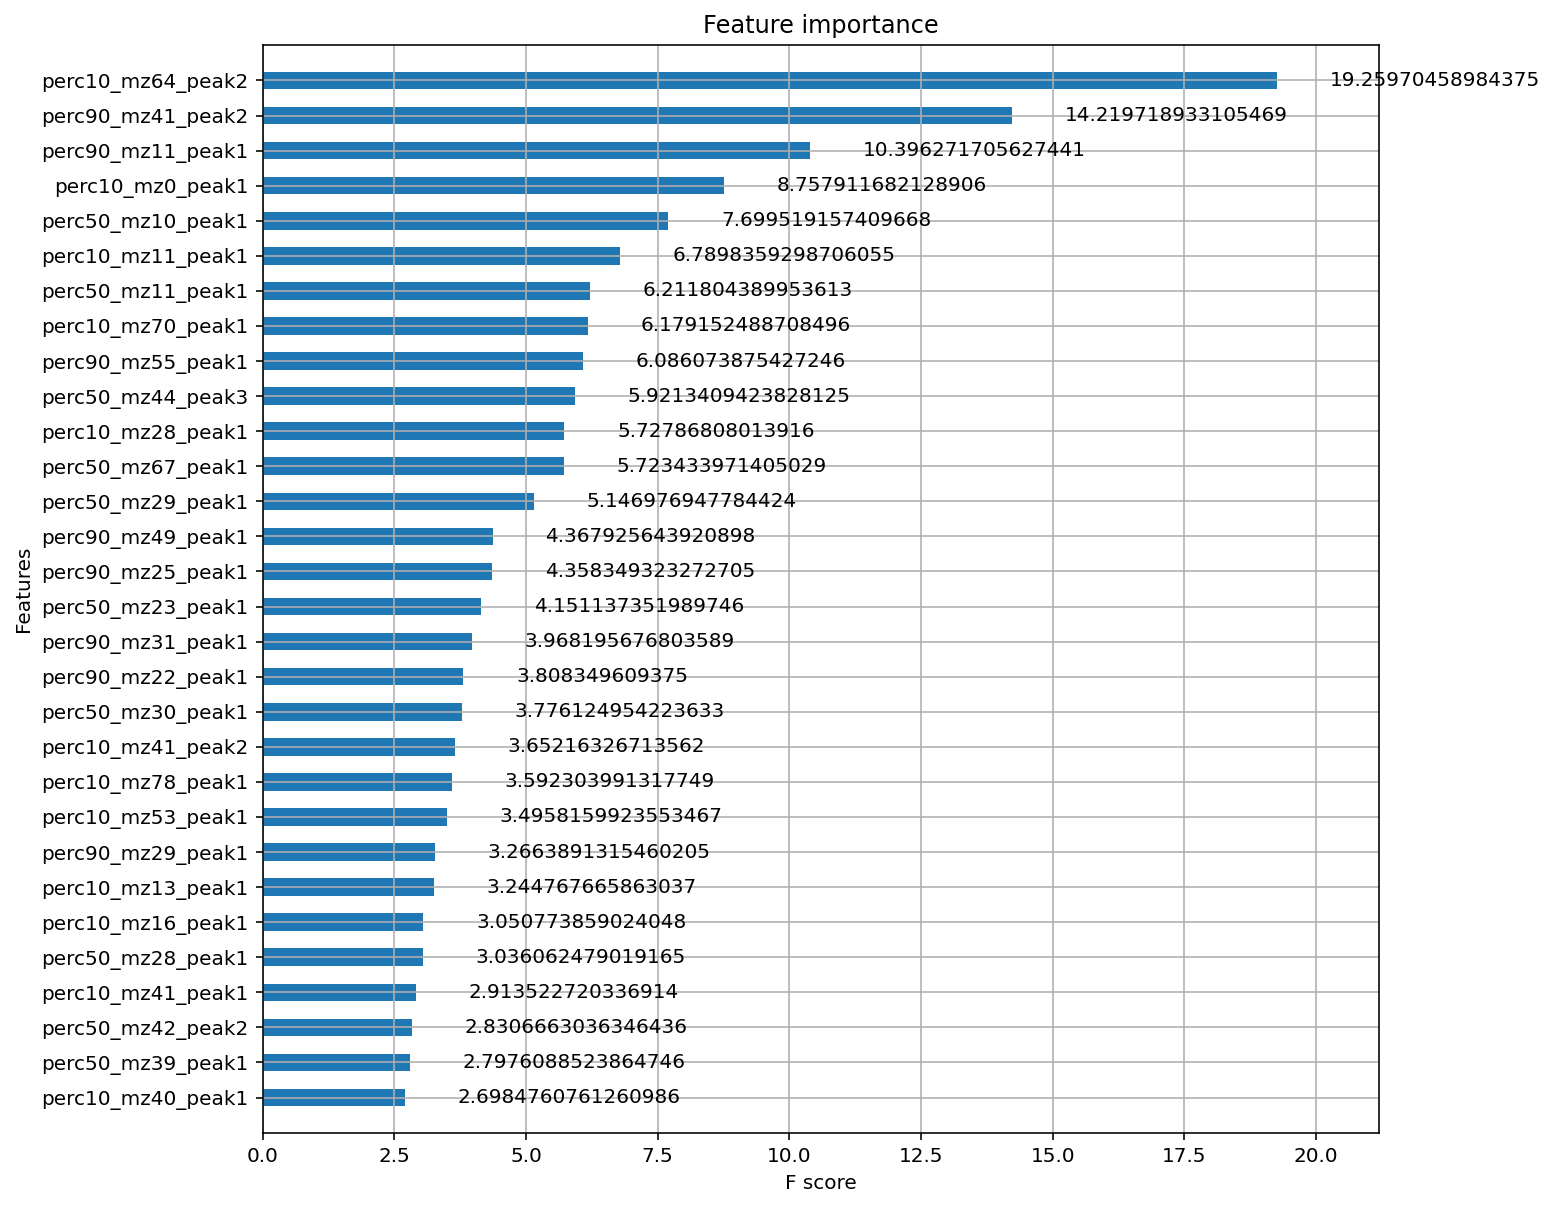

LABEL: chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


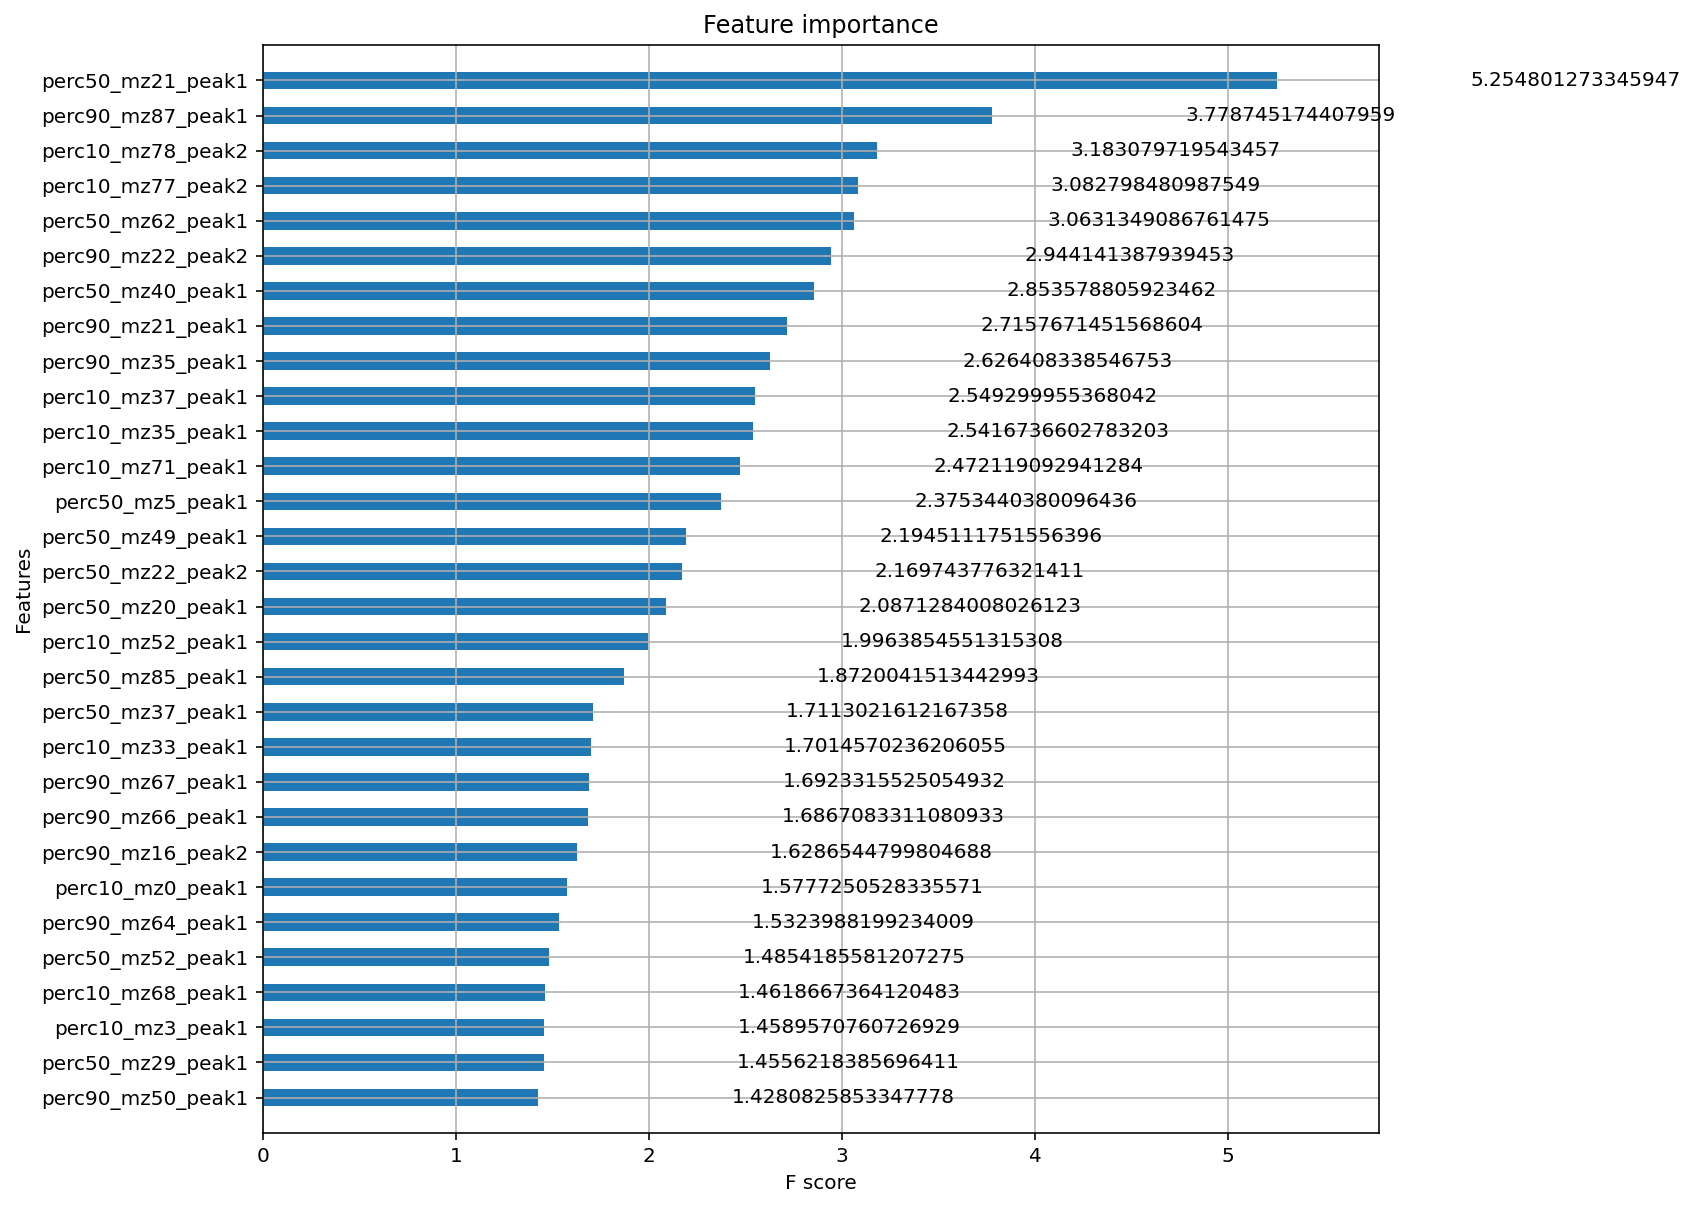

LABEL: iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


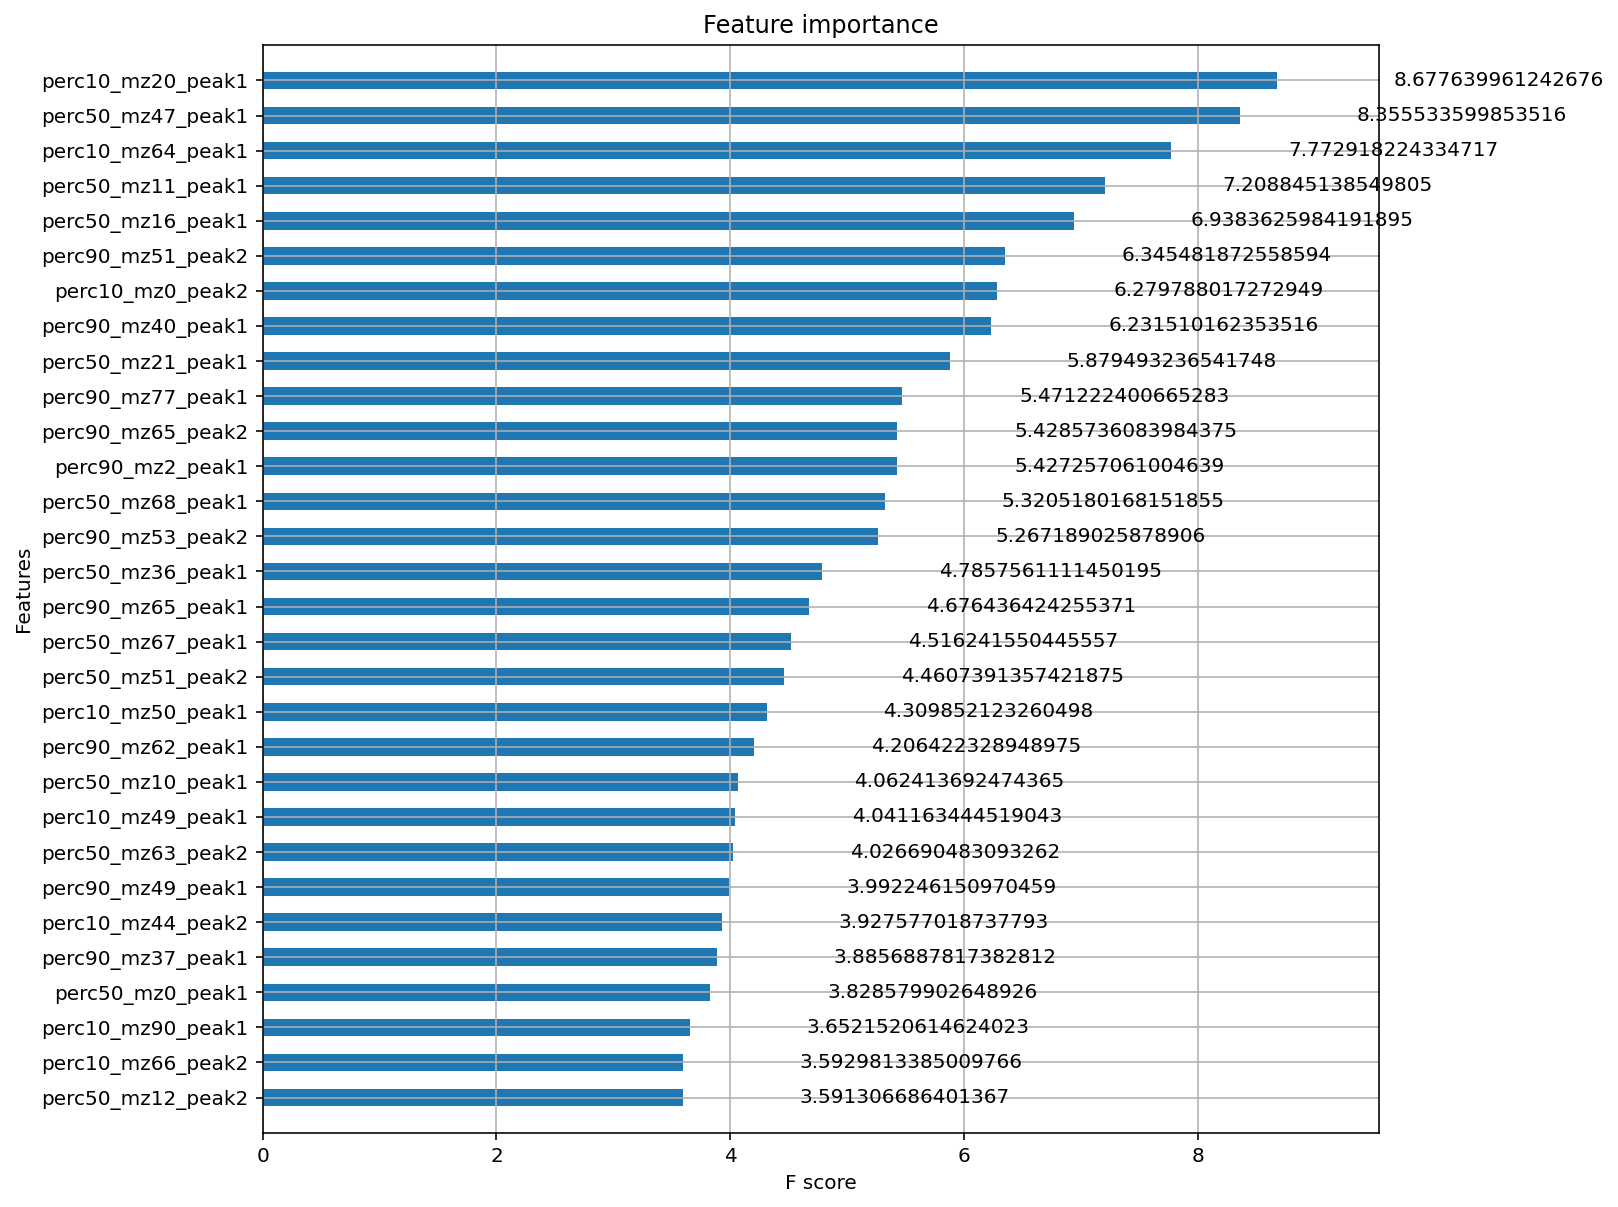

LABEL: oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


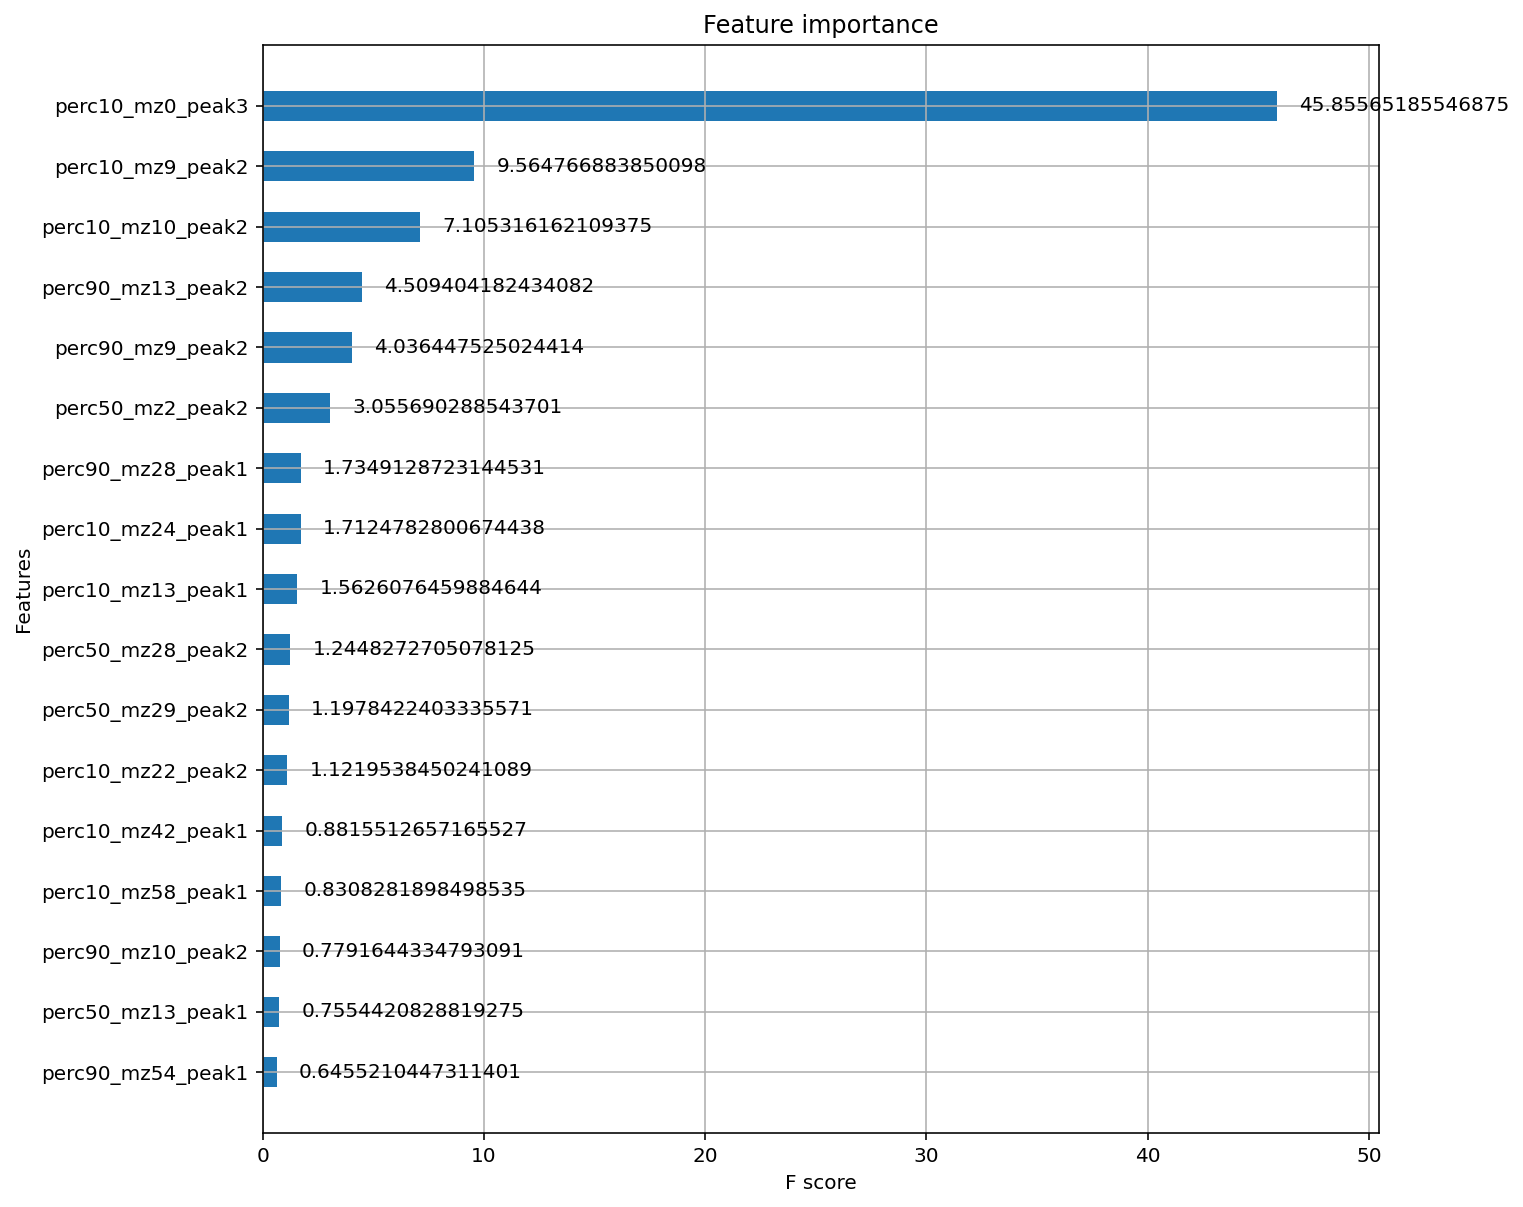

LABEL: oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


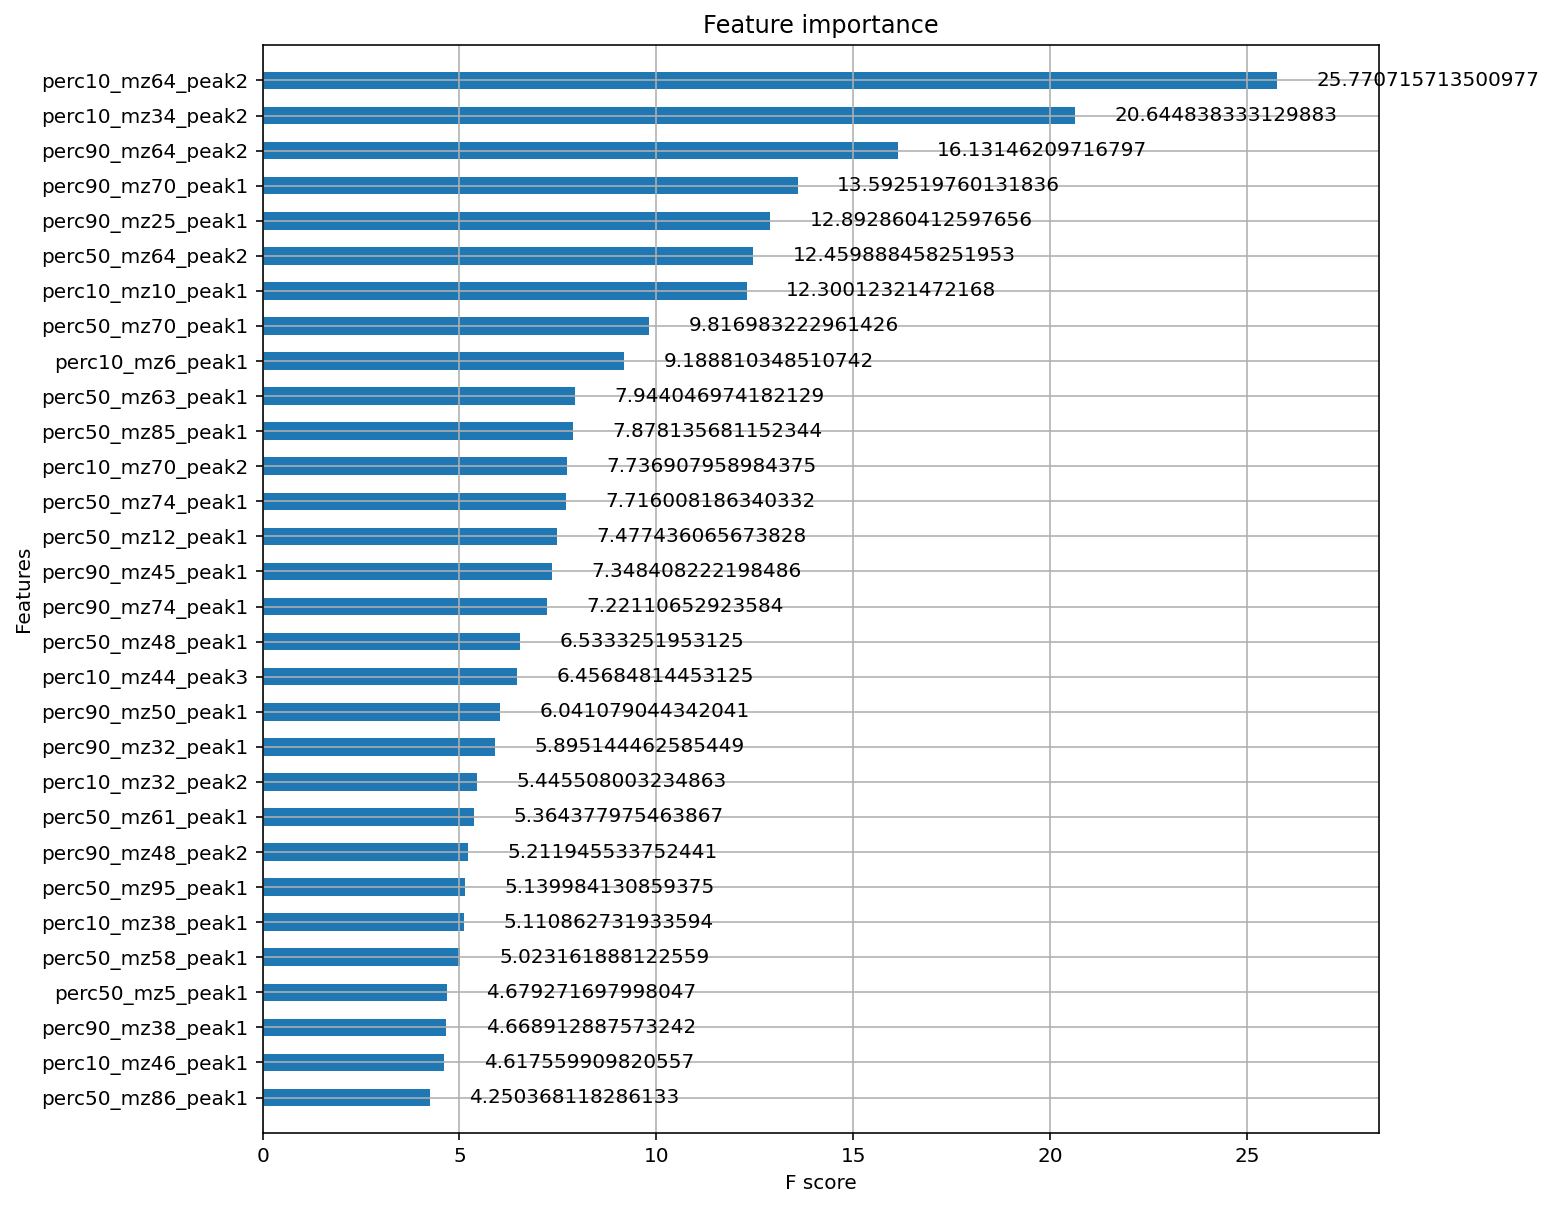

LABEL: phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


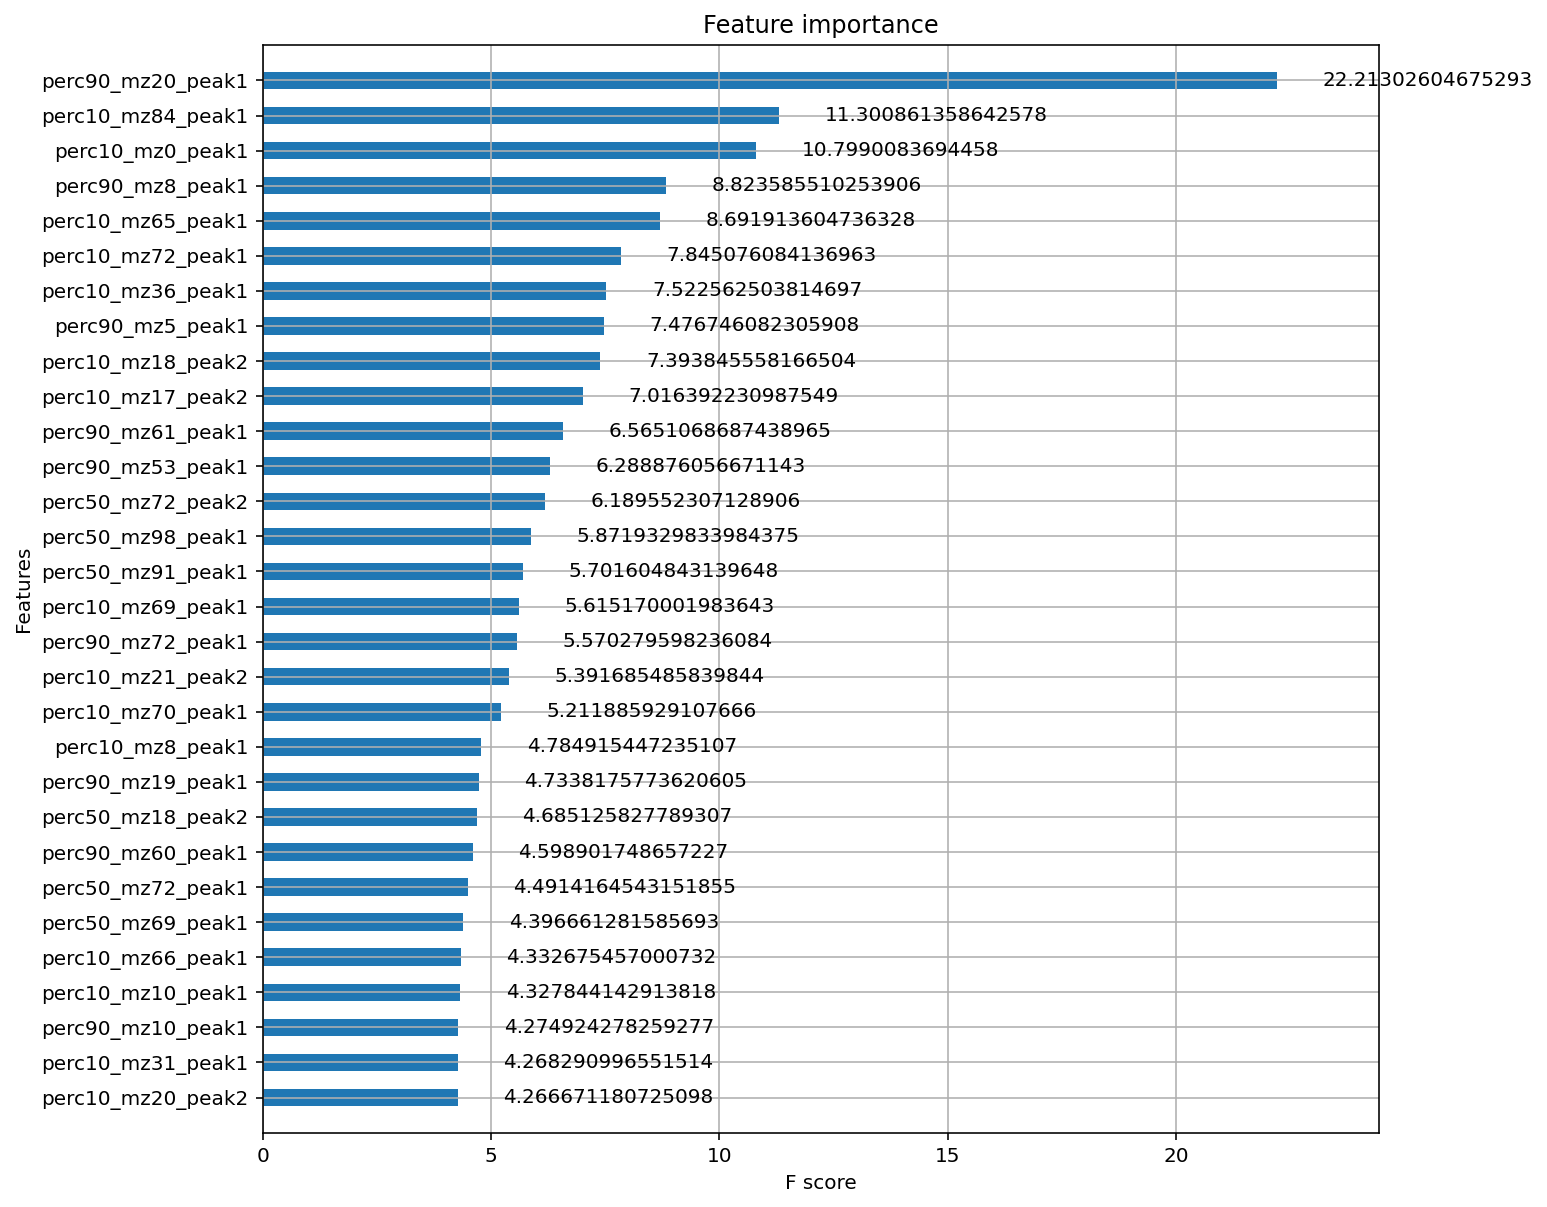

LABEL: silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


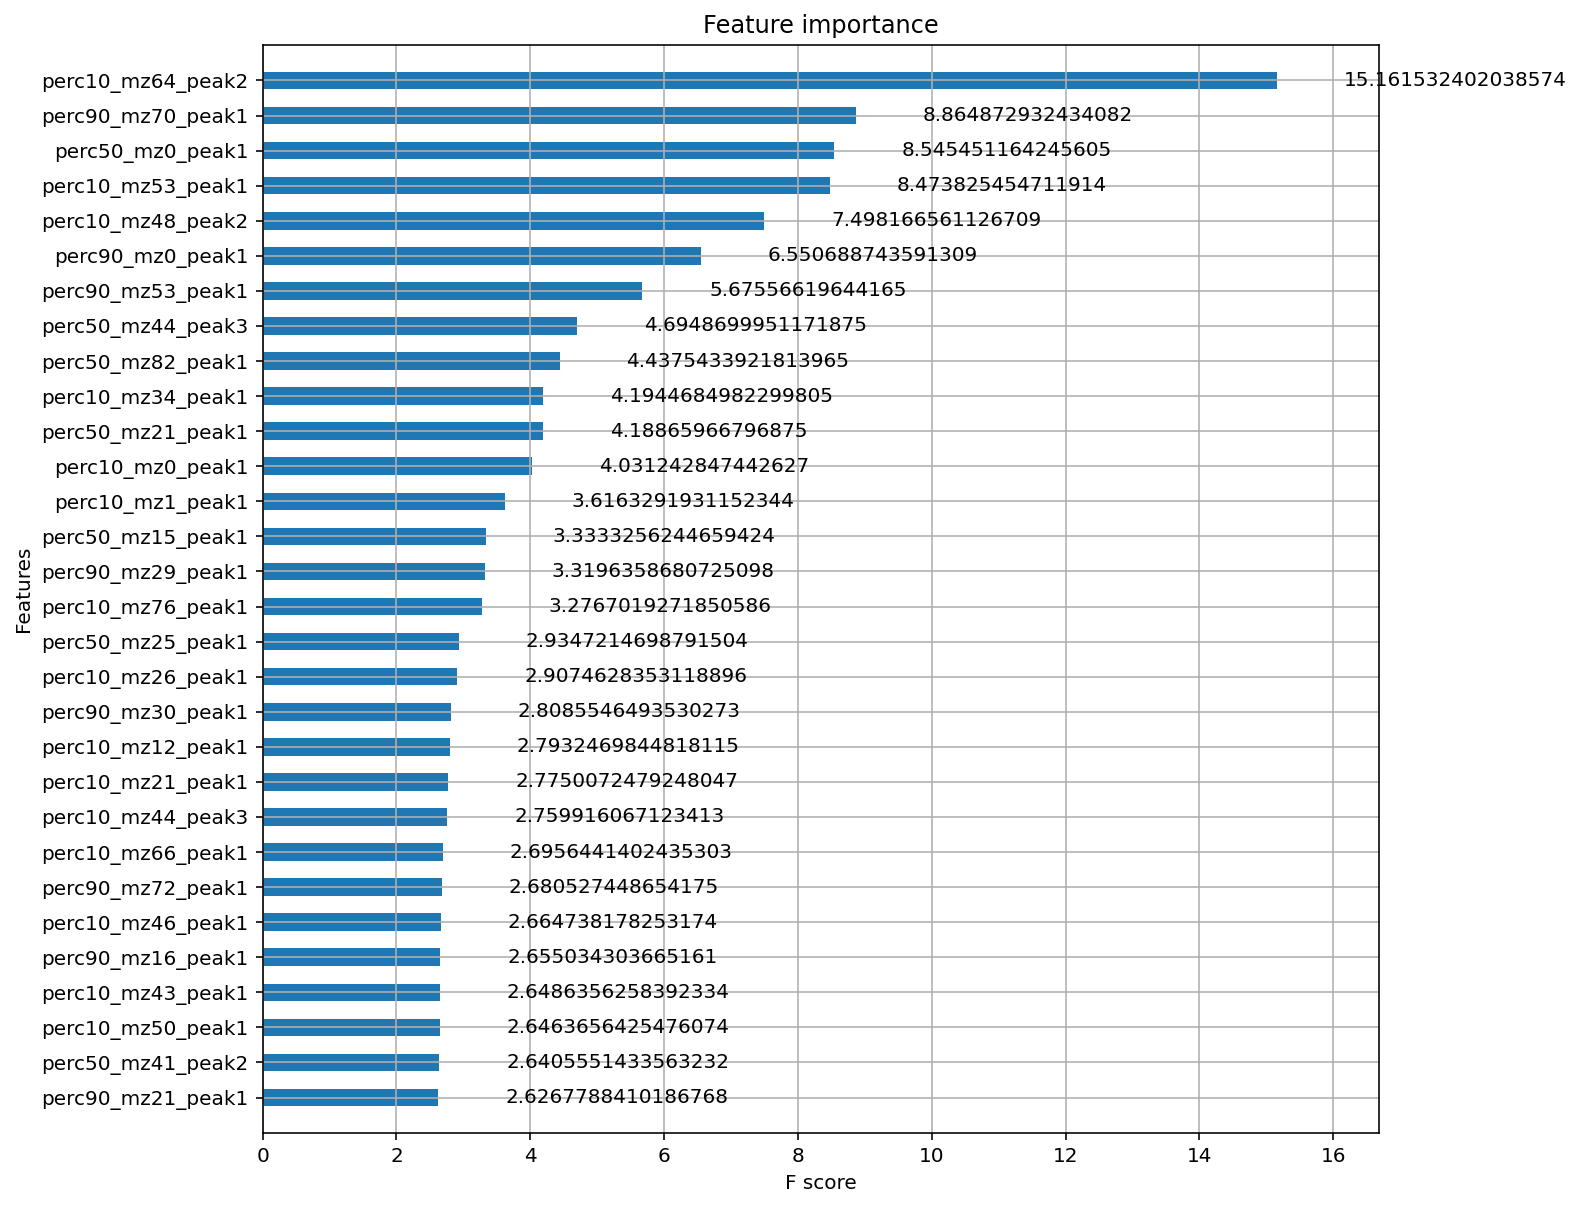

LABEL: sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


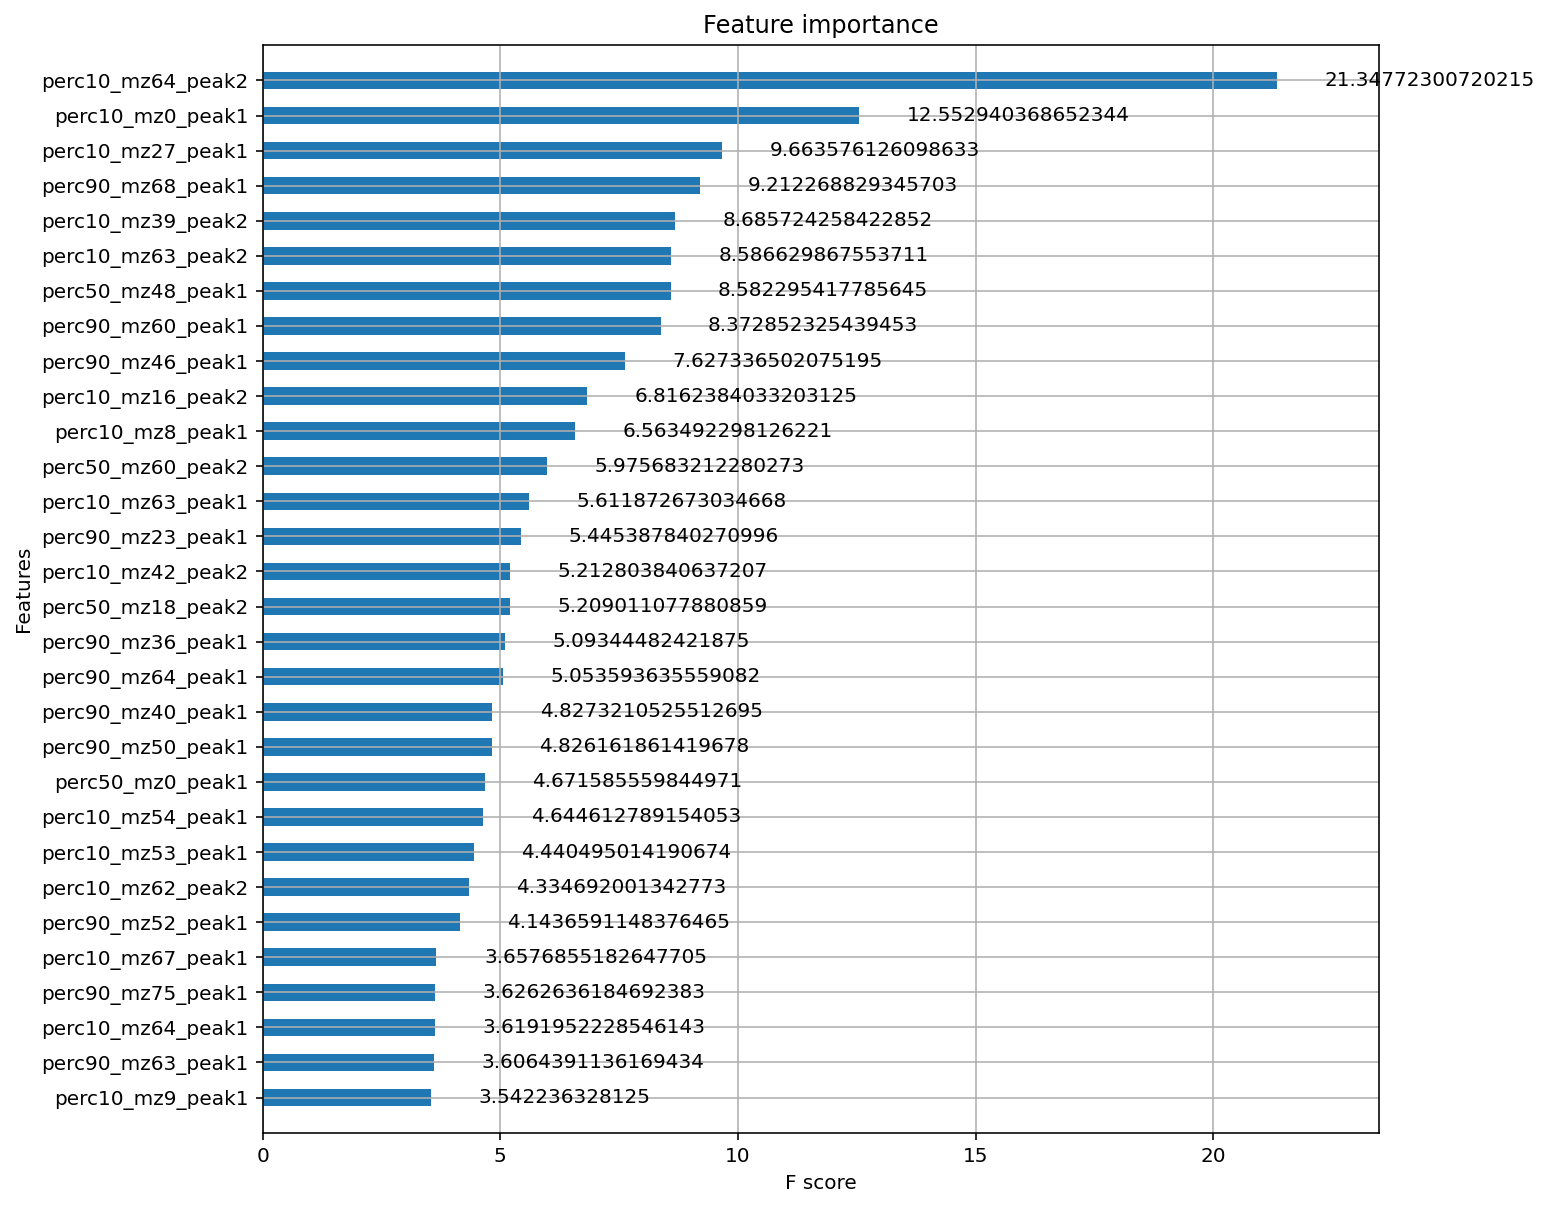

LABEL: sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


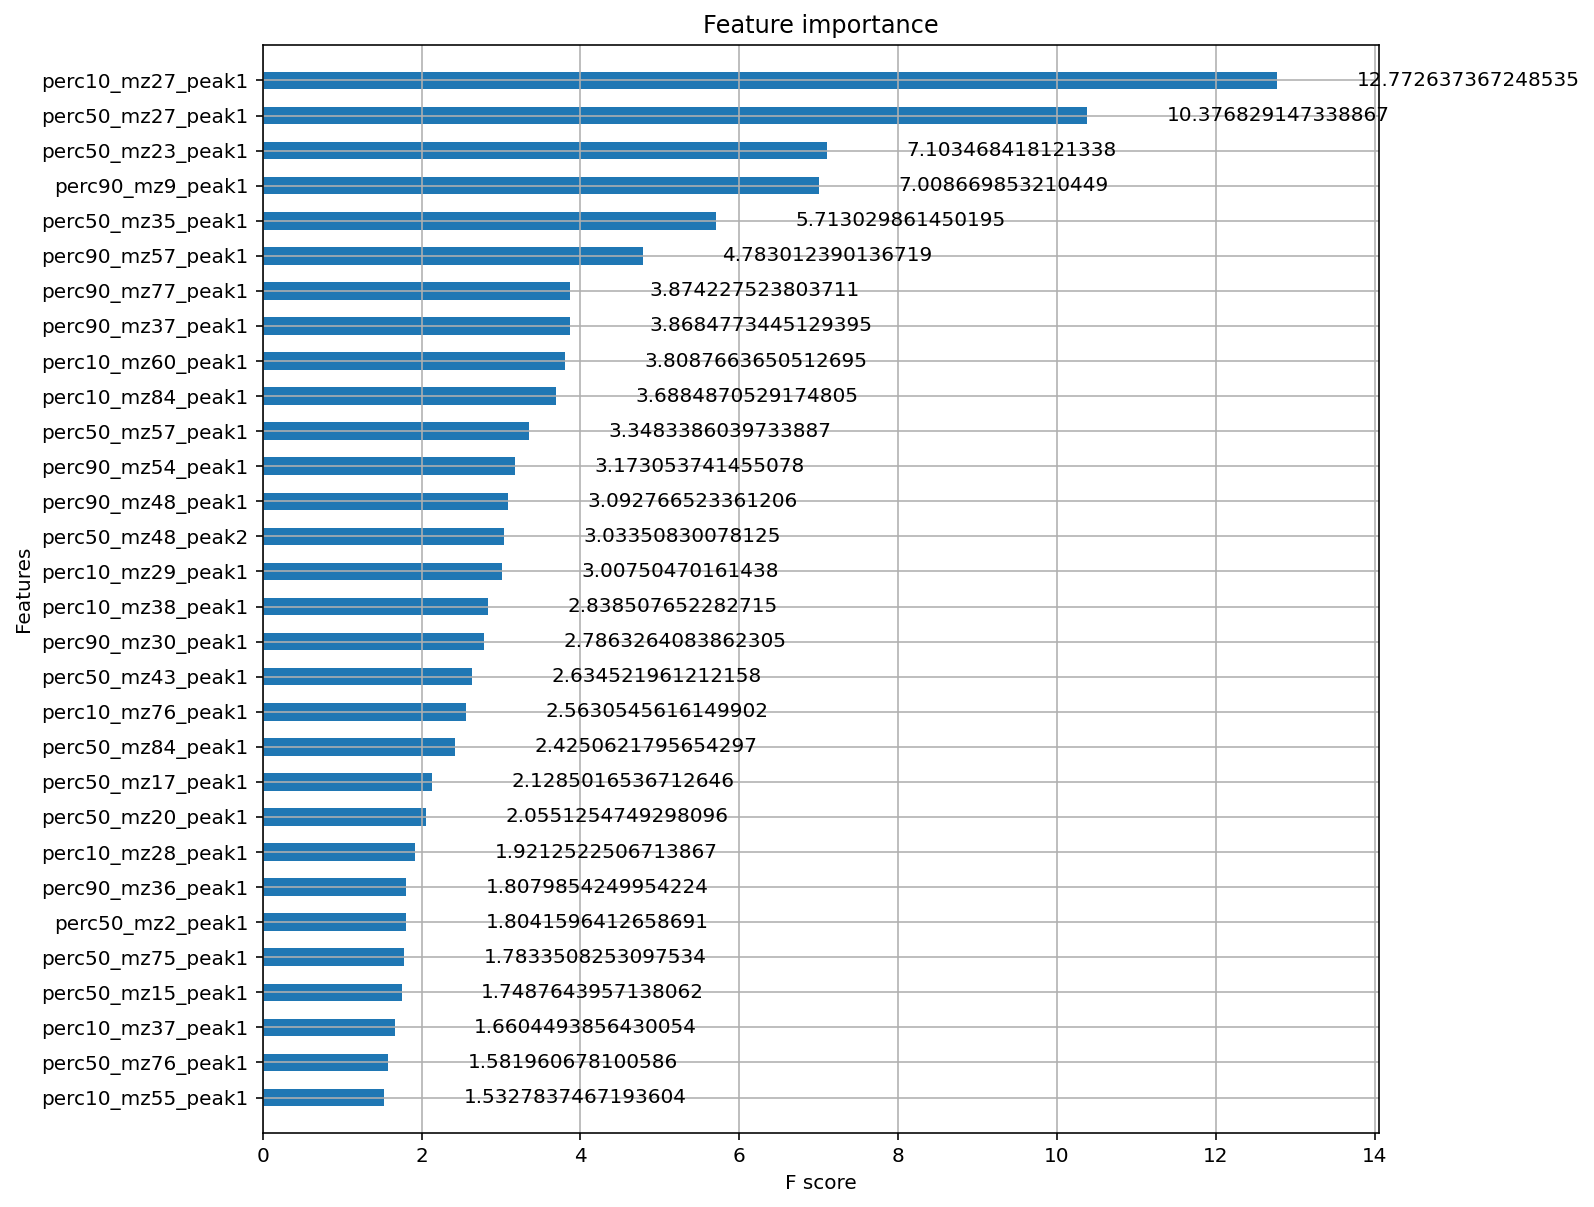


Average Log Loss: 0.2402
Log Loss per Label:
{'basalt': 0.2383828171754525, 'carbonate': 0.18889304304162086, 'chloride': 0.2667375802746641, 'iron_oxide': 0.3418969978527541, 'oxalate': 0.04647222962715143, 'oxychlorine': 0.27234344141625766, 'phyllosilicate': 0.35867775287531484, 'silicate': 0.28724431545417217, 'sulfate': 0.311164347173038, 'sulfide': 0.0898685544631547}
(293, 10)


In [10]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_tr',
    fts_select_cols=SFM_COLUMNS,
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               valid_files, valid_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_tr',
                                               fts_select_cols=True)

In [11]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)

CV Logloss: 0.24016810793535806
VALID FM LogLoss: 0.23366198064936183
CV logLoss Label
{'basalt': 0.2383828171754525, 'carbonate': 0.18889304304162086, 'chloride': 0.2667375802746641, 'iron_oxide': 0.3418969978527541, 'oxalate': 0.04647222962715143, 'oxychlorine': 0.27234344141625766, 'phyllosilicate': 0.35867775287531484, 'silicate': 0.28724431545417217, 'sulfate': 0.311164347173038, 'sulfide': 0.0898685544631547}


**TRAIN & VALID**

In [ ]:
_, SFM_COLUMNS = feature_selection.fts_select(
    target_labels_list, FTS_NAME, MODEL_NAME, 'trvl',
    X_tr, X_vlte, train_labels, valid_files, valid_labels
)

In [ ]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_trvl,
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_trvl'
    )

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'CV logLoss Label')
print(cvloss)

**SAM TRAINING**

In [ ]:
# ===== TRAIN SAM =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr_sam,
    df_labels=sam_labels,
    target_list=target_labels_list,
    df_test=X_vl_sam,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_sam',
    test_sam=True
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               sam_files, sam_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_sam')

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)